## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [17]:
import os
import keras
from keras.layers import BatchNormalization
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [18]:
train, test = keras.datasets.cifar10.load_data()

In [19]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [20]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [21]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [22]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512 

Epoch 46/50
50000/50000 [==============================] - 11s 229us/step - loss: 0.5684 - accuracy: 0.8312 - val_loss: 1.6478 - val_accuracy: 0.4867
Epoch 47/50
50000/50000 [==============================] - 10s 203us/step - loss: 0.5504 - accuracy: 0.8410 - val_loss: 1.6381 - val_accuracy: 0.4868
Epoch 48/50
50000/50000 [==============================] - 10s 204us/step - loss: 0.5346 - accuracy: 0.8448 - val_loss: 1.6559 - val_accuracy: 0.4848
Epoch 49/50
50000/50000 [==============================] - 10s 200us/step - loss: 0.5188 - accuracy: 0.8522 - val_loss: 1.6843 - val_accuracy: 0.4845
Epoch 50/50
10000/10000 [==============================] - 2s 233us/step
loss_loadback 1.4655784065246582
acc_loadback 0.49140000343322754


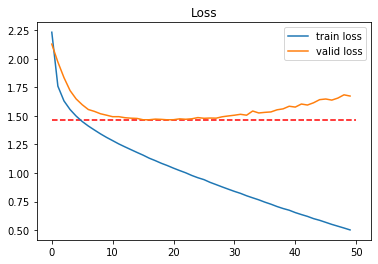

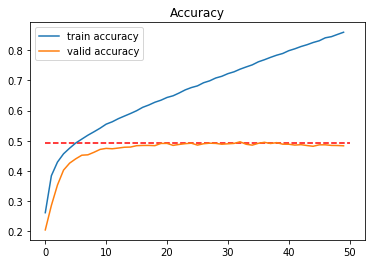

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_12 (Batc (None, 128)               512 

50000/50000 [==============================] - 11s 222us/step - loss: 0.5604 - accuracy: 0.8370 - val_loss: 1.6462 - val_accuracy: 0.4910
Epoch 47/50
50000/50000 [==============================] - 10s 204us/step - loss: 0.5440 - accuracy: 0.8422 - val_loss: 1.6514 - val_accuracy: 0.4875
Epoch 48/50
50000/50000 [==============================] - 10s 191us/step - loss: 0.5269 - accuracy: 0.8499 - val_loss: 1.6533 - val_accuracy: 0.4864
Epoch 49/50
50000/50000 [==============================] - 10s 192us/step - loss: 0.5105 - accuracy: 0.8567 - val_loss: 1.6636 - val_accuracy: 0.4832
Epoch 50/50
10000/10000 [==============================] - 2s 235us/step
loss_loadback 1.6869514389038085
acc_loadback 0.4900999963283539


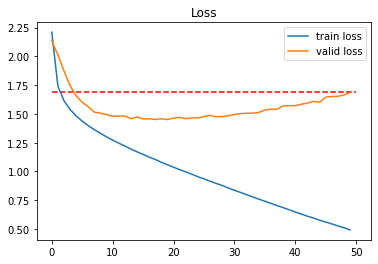

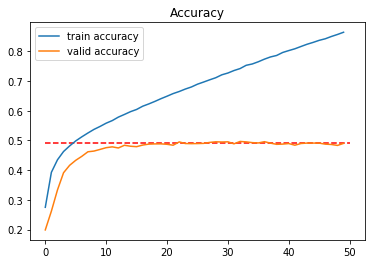

In [23]:
from keras.callbacks import ModelCheckpoint


results = {}

for save_best_only in [True, False]:
    model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss", 
                             save_best_only=save_best_only)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )
    # Collect results    
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    name_tag = 'save_best_only: %s' % str(save_best_only)
    results[name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}
    
    # Load back
    model = keras.models.load_model("./tmp.h5")
    loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
    print("loss_loadback", loss_loadback)
    print("acc_loadback", acc_loadback)

    import matplotlib.pyplot as plt
    %matplotlib inline
    """Code Here
    將結果繪出
    """
    plt.plot(range(len(train_loss)), train_loss, label="train loss")
    plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
    plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
    plt.legend()
    plt.title("Loss")
    plt.show()

    plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
    plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
    plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
    plt.legend()
    plt.title("Accuracy")
    plt.show()

   